In [1]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe import solutions
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2

In [2]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [3]:
#Creating the Landmark object
base_options = python.BaseOptions(model_asset_path='../models/pose_landmarker_heavy.task')
VisionRunningMode = mp.tasks.vision.RunningMode
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True,
    running_mode=vision.RunningMode.VIDEO,
    min_pose_detection_confidence=0.6,
    min_pose_presence_confidence=0.7,
    min_tracking_confidence=0.95,
)
detector = vision.PoseLandmarker.create_from_options(options)

In [4]:
VIDEO_PATH    = "../data/raw/video0.mp4"
OUTPUT_PATH   = "../data/processed/video0_annotated_new.mp4"

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video file: {VIDEO_PATH}")

fps    = cap.get(cv2.CAP_PROP_FPS) or 30.0
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')              # or 'avc1', 'XVID', etc.
out    = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

keypoints = []
frame_idx = 0

while True:
    success, frame_bgr = cap.read()
    if not success:
        break
    
    frame_idx += 1
    
    frame_rgb  = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    mp_image   = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))
    result     = detector.detect_for_video(mp_image, timestamp_ms)
    if not result.pose_landmarks:
        print(f"No pose landmarks detected in frame {frame_idx}")
        continue

    if result.pose_landmarks:
        lm = result.pose_landmarks[0]
        coords = np.array(
            [[l.x, l.y, l.z] for l in lm],
            dtype=np.float32
        )
    else:
        coords = np.zeros((len(solutions.pose.PoseLandmark), 3), dtype=np.float32)

    keypoints.append(coords)

    annotated_rgb = draw_landmarks_on_image(frame_rgb, result)
    annotated_bgr = cv2.cvtColor(annotated_rgb, cv2.COLOR_RGB2BGR)

    out.write(annotated_bgr)

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Saved annotated video to {OUTPUT_PATH}")


No pose landmarks detected in frame 314
No pose landmarks detected in frame 319
No pose landmarks detected in frame 320
No pose landmarks detected in frame 321
No pose landmarks detected in frame 322
No pose landmarks detected in frame 323
No pose landmarks detected in frame 324
No pose landmarks detected in frame 325
No pose landmarks detected in frame 326
No pose landmarks detected in frame 327
No pose landmarks detected in frame 328
No pose landmarks detected in frame 329
No pose landmarks detected in frame 330
No pose landmarks detected in frame 331
No pose landmarks detected in frame 332
No pose landmarks detected in frame 333
No pose landmarks detected in frame 334
No pose landmarks detected in frame 335
No pose landmarks detected in frame 336
No pose landmarks detected in frame 337
No pose landmarks detected in frame 339
No pose landmarks detected in frame 340
No pose landmarks detected in frame 341
No pose landmarks detected in frame 342
No pose landmarks detected in frame 343


# Phase Segmentation

In [5]:
import os

kp_array = np.stack(keypoints, axis=0)  # shape = (F, L, 3)
os.makedirs(os.path.dirname("D:/Projects/TrueForm/data/keypoints"), exist_ok=True)
np.save("D:/Projects/TrueForm/data/keypoints/video0_landmarks.npy", kp_array)
print(f"Saved landmarks array to {'D:/Projects/TrueForm/data/keypoints/video0_landmarks.npy'}")

Saved landmarks array to D:/Projects/TrueForm/data/keypoints/video0_landmarks.npy


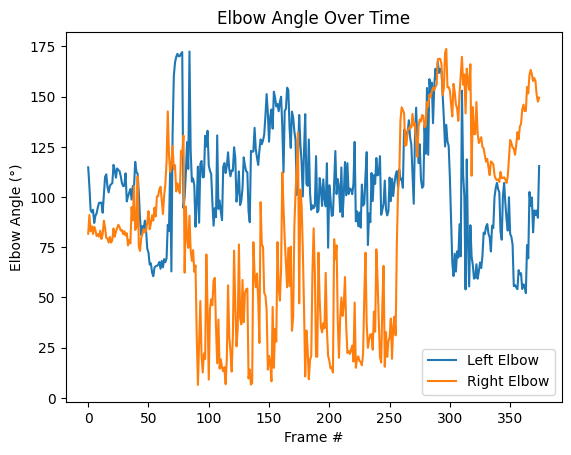

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt


def angle_between(a, b, c):
    ba = a - b
    bc = c - b
    cos_ang = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return math.degrees(math.acos(np.clip(cos_ang, -1.0, 1.0)))

landmarks = np.load('../data/keypoints/video0_landmarks.npy')  # shape (F,33,3)
F = landmarks.shape[0]

# Preallocating arrays for angles
left_elbow = np.zeros(F)
right_elbow = np.zeros(F)


L = solutions.pose.PoseLandmark

for i in range(F):
    coords = landmarks[i]
    left_elbow[i]  = angle_between(
        coords[L.LEFT_SHOULDER.value],
        coords[L.LEFT_ELBOW.value],
        coords[L.LEFT_WRIST.value]
    )
    right_elbow[i] = angle_between(
        coords[L.RIGHT_SHOULDER.value],
        coords[L.RIGHT_ELBOW.value],
        coords[L.RIGHT_WRIST.value]
    )

# Plot
plt.figure()
plt.plot(range(F), left_elbow, label='Left Elbow')
plt.plot(range(F), right_elbow, label='Right Elbow')
plt.xlabel('Frame #')
plt.ylabel('Elbow Angle (°)')
plt.title('Elbow Angle Over Time')
plt.legend()
plt.show()

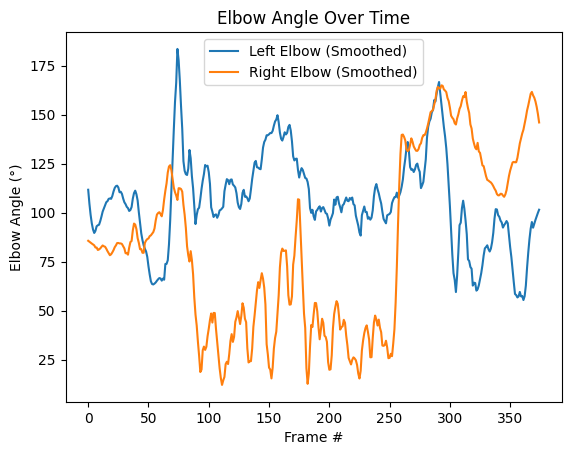

In [7]:
from scipy.signal import savgol_filter
from scipy.signal import find_peaks


window_length = 11  # must be odd, and < len(signal)
polyorder     = 2

left_smooth  = savgol_filter(left_elbow,  window_length, polyorder)
right_smooth = savgol_filter(right_elbow, window_length, polyorder)

plt.figure()
plt.plot(range(F), left_smooth, label='Left Elbow (Smoothed)')
plt.plot(range(F), right_smooth, label='Right Elbow (Smoothed)')
plt.xlabel('Frame #')
plt.ylabel('Elbow Angle (°)')
plt.title('Elbow Angle Over Time')
plt.legend()
plt.show()

In [8]:
peaks, props = find_peaks(left_smooth, height=155, distance=60)
# – height=155° ensures we only pick “full-draw” peaks
# – distance=30 frames separates shots by at least 1 second (if 30 fps)

print(f"Detected {len(peaks)} shots at frames {peaks}")

Detected 2 shots at frames [ 74 291]


In [9]:
shot_metrics = []
for p in peaks:
    # find where this draw started (local trough before p)
    start = np.argmin(left_smooth[max(0, p-50):p]) + max(0, p-50)
    peak_angle = left_smooth[p]
    hold_var   = np.std(left_smooth[p-10:p])
    pull_rate  = (peak_angle - left_smooth[start]) / (p - start)
    shot_metrics.append({
        "frame_start": start,
        "frame_peak" : p,
        "peak_angle" : peak_angle,
        "hold_variance": hold_var,
        "pull_rate": pull_rate,
    })

In [11]:
shot_metrics

[{'frame_start': np.int64(54),
  'frame_peak': np.int64(74),
  'peak_angle': np.float64(183.47117120039357),
  'hold_variance': np.float64(33.682052553416476),
  'pull_rate': np.float64(6.006105643158522)},
 {'frame_start': np.int64(247),
  'frame_peak': np.int64(291),
  'peak_angle': np.float64(166.58815946714682),
  'hold_variance': np.float64(7.5931298346238885),
  'pull_rate': np.float64(1.6376932341555894)}]

In [12]:
import pandas as pd

# --- 1) Build DataFrame from your list of dicts:
df = pd.DataFrame(shot_metrics)
df.index.name = "shot_idx"

# --- 2) Add right-arm peak angle & symmetry difference:
# (we’ll assume the same peak frames correspond on right side)
df['peak_angle_R'] = right_smooth[df['frame_peak']]
df['symmetry_diff'] = (df['peak_angle'] - df['peak_angle_R']).abs()

# --- 3) Shot duration (frames → seconds):
df['duration_s'] = (df['frame_peak'] - df['frame_start']) / fps

# --- 4) Consistency score (higher = steadier hold):
# simple example: 1 / (1 + hold_variance)
df['consistency_score'] = 1.0 / (1.0 + df['hold_variance'])

# Quick look:
print(df[['frame_start','frame_peak',
          'peak_angle','peak_angle_R','symmetry_diff',
          'hold_variance','pull_rate','duration_s','consistency_score']])


          frame_start  frame_peak  peak_angle  peak_angle_R  symmetry_diff  \
shot_idx                                                                     
0                  54          74  183.471171    106.449704      77.021468   
1                 247         291  166.588159    163.351313       3.236847   

          hold_variance  pull_rate  duration_s  consistency_score  
shot_idx                                                           
0             33.682053   6.006106    0.666667           0.028833  
1              7.593130   1.637693    1.466667           0.116372  


In [13]:
def dist(a, b):
    return np.linalg.norm(a - b)

# for each shot, measure ankle‐to‐ankle distance at the peak frame
stance_widths = []
for _, row in df.iterrows():
    coords = landmarks[int(row['frame_peak'])]
    lw = coords[L.LEFT_ANKLE.value]
    rw = coords[L.RIGHT_ANKLE.value]
    stance_widths.append(dist(lw, rw))

df['stance_width'] = stance_widths

# View updated table
print(df[['peak_angle','symmetry_diff','stance_width']])


          peak_angle  symmetry_diff  stance_width
shot_idx                                         
0         183.471171      77.021468      0.567444
1         166.588159       3.236847      0.386662


In [14]:
df.to_csv('video1_shot_metrics.csv')

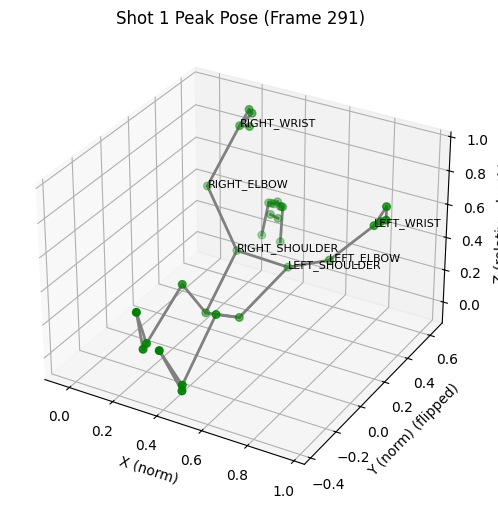

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mediapipe import solutions

# coords is your (33,3) array from landmarks[frame_peak]
coords = coords.copy()  # don't overwrite original if you need it later

# 1) Flip Y so 'up' is positive (image coords -> Cartesian-like)
coords[:, 1] = 1.0 - coords[:, 1]

# 2) Optionally invert Z if you want forward (toward camera) to be positive:
# Try with and without this line to see which matches your intuition
coords[:, 2] = -coords[:, 2]

# 3) helper to set equal aspect in 3D
def set_axes_equal(ax):
    """Make 3D axes have equal scale."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    max_range = max(x_range, y_range, z_range)
    x_mid = np.mean(x_limits)
    y_mid = np.mean(y_limits)
    z_mid = np.mean(z_limits)
    ax.set_xlim3d(x_mid - max_range/2, x_mid + max_range/2)
    ax.set_ylim3d(y_mid - max_range/2, y_mid + max_range/2)
    ax.set_zlim3d(z_mid - max_range/2, z_mid + max_range/2)

# 4) Colored joints & labels (example)
L = solutions.pose.PoseLandmark
elbows = (L.LEFT_ELBOW.value, L.RIGHT_ELBOW.value)
colors = ['red' if i in elbows and shot['symmetry_diff'] > 5 else 'green' for i in range(coords.shape[0])]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title(f'Shot {shot_idx} Peak Pose (Frame {frame_peak})')

ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=colors, s=30)
# draw bones (connections are pairs of ints)
for s,e in solutions.pose.POSE_CONNECTIONS:
    a = coords[s]; b = coords[e]
    ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]], c='gray', lw=2)

# annotate a few key landmarks so you can sanity-check left/right
for idx in [L.LEFT_SHOULDER.value, L.RIGHT_SHOULDER.value, L.LEFT_ELBOW.value, L.RIGHT_ELBOW.value, L.LEFT_WRIST.value, L.RIGHT_WRIST.value]:
    ax.text(coords[idx,0], coords[idx,1], coords[idx,2], L(idx).name, fontsize=8)

ax.set_xlabel('X (norm)')
ax.set_ylabel('Y (norm) (flipped)')
ax.set_zlabel('Z (relative depth)')
set_axes_equal(ax)
plt.show()


In [21]:
import cv2
import numpy as np
import pandas as pd
import math
from mediapipe import solutions

# ---------- CONFIG ----------
VIDEO_PATH      = "../data/raw/video1.mp4"
LANDMARKS_PATH  = "../data/keypoints/video1_landmarks.npy"
METRICS_PATH    = "video1_shot_metrics.csv"
OUTPUT_PATH     = "../data/processed/video1_with_corrections.mp4"

# Numeric thresholds (tune these)
TH_SYMMETRY_DEG = 5.0     # degrees: peak left/right elbow difference
TH_HOLD_VAR     = 2.0     # degrees: stddev of hold angle
TH_STANCE_RATIO_MIN = 0.8 # stance_width / shoulder_span < -> too narrow
TH_STANCE_RATIO_MAX = 1.5 # > -> too wide
TH_RELEASE_JERK = 10.0    # degrees/frame: big change right after release
HOLD_WINDOW_FRAMES = 10   # frames before peak considered "hold"

# ---------- helpers ----------
L = solutions.pose.PoseLandmark

def dist(a, b):
    return np.linalg.norm(a - b)

def angle_between(a, b, c):
    ba = a - b
    bc = c - b
    denom = (np.linalg.norm(ba) * np.linalg.norm(bc))
    if denom == 0:
        return 0.0
    cosang = np.dot(ba, bc) / denom
    return math.degrees(math.acos(np.clip(cosang, -1.0, 1.0)))

def normalized_to_pixel(norm_pt, width, height):
    # norm_pt is (x,y,z)
    return int(norm_pt[0] * width), int(norm_pt[1] * height)

def draw_text_box(img, text_lines, origin=(10,30), font_scale=0.6, thickness=1, bgcolor=(0,0,0,160)):
    x0, y0 = origin
    font = cv2.FONT_HERSHEY_SIMPLEX
    # compute box size
    w = 0
    h = 0
    for i, line in enumerate(text_lines):
        (tw, th), _ = cv2.getTextSize(line, font, font_scale, thickness)
        w = max(w, tw)
        h += th + 8
    # draw background rectangle
    cv2.rectangle(img, (x0-8, y0-18), (x0+w+8, y0 + h), (0,0,0), -1)
    # put text
    y = y0
    for line in text_lines:
        cv2.putText(img, line, (x0, y), font, font_scale, (255,255,255), thickness, cv2.LINE_AA)
        y += int(th + 8)

# ---------- load data ----------
landmarks_all = np.load(LANDMARKS_PATH)  # shape (F, 33, 3)
df = pd.read_csv(METRICS_PATH, index_col='shot_idx')
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError("Can't open video.")

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (W, H))

# Precompute some per-shot diagnostics (more could be added)
diagnostics = {}  # shot_idx -> dict

for shot_idx, row in df.iterrows():
    peak = int(row['frame_peak'])
    start = int(row['frame_start'])
    # shoulder span at peak (normalized)
    coords_peak = landmarks_all[peak]
    shoulder_span = dist(coords_peak[L.LEFT_SHOULDER.value], coords_peak[L.RIGHT_SHOULDER.value])
    # stance width already in df (assumed normalized)
    stance_w = row.get('stance_width', None)
    stance_ratio = None
    if stance_w is not None and shoulder_span > 0:
        stance_ratio = stance_w / shoulder_span

    # hold variance and symmetry already present in df
    hold_var = row.get('hold_variance', 0.0)
    symmetry = row.get('symmetry_diff', 0.0)

    # Release jerk: compute change in elbow angle immediately after peak
    # use left elbow angle time series approximated from landmarks
    # we'll compute left elbow angle for frames [peak, peak+3]
    left_angles = []
    for f in range(peak, min(peak+4, landmarks_all.shape[0])):
        c = landmarks_all[f]
        a = angle_between(c[L.LEFT_SHOULDER.value], c[L.LEFT_ELBOW.value], c[L.LEFT_WRIST.value])
        left_angles.append(a)
    release_jerk = 0.0
    if len(left_angles) >= 2:
        release_jerk = max(abs(left_angles[i+1] - left_angles[i]) for i in range(len(left_angles)-1))
    # head stability: stddev of nose during hold window
    hold_start = max(start, peak - HOLD_WINDOW_FRAMES)
    nose_positions = landmarks_all[hold_start:peak, L.NOSE.value] if peak > hold_start else np.array([])
    head_std = 0.0
    if len(nose_positions) > 0:
        # compute pixel variance in y as proxy for vertical stability
        head_std = float(np.std(nose_positions[:,1]))

    diagnostics[shot_idx] = {
        "shoulder_span": shoulder_span,
        "stance_w": stance_w,
        "stance_ratio": stance_ratio,
        "hold_var": float(hold_var),
        "symmetry": float(symmetry),
        "release_jerk": float(release_jerk),
        "head_std": float(head_std),
        "frame_start": start,
        "frame_peak": peak
    }

# ---------- main overlay loop ----------
frame_idx = 0
# Build shot lookup by frame range for quick per-frame shot mapping
shots_by_frame = {}
for shot_idx, diag in diagnostics.items():
    s = int(diag['frame_start'])
    p = int(diag['frame_peak'])
    # annotate from start to (peak + 10) frames to include release
    end = min(p + 10, landmarks_all.shape[0]-1)
    for f in range(s, end+1):
        shots_by_frame[f] = shot_idx

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
while True:
    ret, frame = cap.read()
    if not ret:
        break

    h, w = frame.shape[:2]
    annotated = frame.copy()

    if frame_idx < len(landmarks_all):
        lm_norm = landmarks_all[frame_idx]  # (33,3)
    else:
        lm_norm = None

    if frame_idx in shots_by_frame and lm_norm is not None:
        shot_idx = shots_by_frame[frame_idx]
        diag = diagnostics[shot_idx]
        s = diag['frame_start']
        p = diag['frame_peak']

        # compute suggestion list
        suggestions = []
        bad_joints = []

        if diag['symmetry'] > TH_SYMMETRY_DEG:
            suggestions.append(f"Asymmetric draw: Δ{diag['symmetry']:.1f}° between arms")
            bad_joints += [L.LEFT_ELBOW.value, L.RIGHT_ELBOW.value]
        if diag['hold_var'] > TH_HOLD_VAR:
            suggestions.append("Unstable anchor: hold variance high")
            bad_joints += [L.LEFT_WRIST.value, L.RIGHT_WRIST.value]
        if diag['stance_ratio'] is not None:
            if diag['stance_ratio'] < TH_STANCE_RATIO_MIN:
                suggestions.append("Stance too narrow: widen feet")
                bad_joints += [L.LEFT_ANKLE.value, L.RIGHT_ANKLE.value]
            elif diag['stance_ratio'] > TH_STANCE_RATIO_MAX:
                suggestions.append("Stance too wide: bring feet closer")
                bad_joints += [L.LEFT_ANKLE.value, L.RIGHT_ANKLE.value]
        if diag['release_jerk'] > TH_RELEASE_JERK:
            suggestions.append("Jerky release detected: work on smooth follow-through")
            bad_joints += [L.LEFT_WRIST.value]
        if diag['head_std'] > 0.02:  # normalized pos variance threshold (tune)
            suggestions.append("Head movement high during hold: stabilize head")
            bad_joints += [L.NOSE.value]

        if len(suggestions) == 0:
            suggestions = ["No major issues detected — good draw!"]

        # Draw landmarks + flag joints
        # convert normalized to pixels
        pix = {}
        for i in range(lm_norm.shape[0]):
            x_px = int(lm_norm[i,0] * w)
            y_px = int(lm_norm[i,1] * h)
            pix[i] = (x_px, y_px)
        # draw bones (use media pipe connections but they are ints)
        for a,b in solutions.pose.POSE_CONNECTIONS:
            # a,b may be ints or pairs; treat as ints
            pa = pix[int(a)]
            pb = pix[int(b)]
            cv2.line(annotated, pa, pb, (180,180,180), 2)

        # draw joints: red if in bad_joints else green
        for i, (x,y) in pix.items():
            color = (0,255,0) if i not in bad_joints else (0,0,255)
            cv2.circle(annotated, (x,y), 6, color, -1)
            # annotate left/right shoulders for orientation clarity
            if i in (L.LEFT_SHOULDER.value, L.RIGHT_SHOULDER.value):
                cv2.putText(annotated, 'L-S' if i==L.LEFT_SHOULDER.value else 'R-S',
                            (x+6, y-6), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (220,220,220), 1, cv2.LINE_AA)

        # Draw an arrow showing target direction (optional): use vector from hips to nose as rough facing
        hip_mid = ((lm_norm[L.LEFT_HIP.value] + lm_norm[L.RIGHT_HIP.value]) / 2.0)
        nose = lm_norm[L.NOSE.value]
        hip_px = normalized_to_pixel(hip_mid, w, h)
        nose_px = normalized_to_pixel(nose, w, h)
        cv2.arrowedLine(annotated, hip_px, nose_px, (255,200,0), 2, tipLength=0.15)

        # Put suggestions text box
        draw_text_box(annotated, suggestions, origin=(10,30))

        # Draw shot label/metadata
        cv2.putText(annotated, f"Shot {shot_idx} Frame {frame_idx}", (10, H-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)

    # Optionally draw frame index
    cv2.putText(annotated, f"Frame {frame_idx}", (W-160, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)

    out.write(annotated)
    frame_idx += 1

cap.release()
out.release()
print("Saved annotated video to:", OUTPUT_PATH)


Saved annotated video to: ../data/processed/video1_with_corrections.mp4
